In [ ]:
# Zhuofan Dong
# zfdong@uchicago.edu

In [ ]:
# Codes from duke.py file credit to Adam Duke

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


CVOLSymbols = {
  'clvl': 'WTI Crude Oil CVOL',
  'mvl': 'Metals CVOL',
  'gcvl': 'Gold CVOL',
  'euvl': 'EUR/USD CVOL',
  'cvl': 'Corn CVOL',
  'tyvy': 'US10Y Note Yield CVOL',
  'tyvl': 'US10Y Note Price CVOL',
  'srv': '3M SOFR CVOL'
}


FuturesSymbols = {
  'C': 'Corn Futures',
  'CL': 'WTI Crude Oil Futures',
  'GC': 'Gold Futures',
  'TYF': 'US10Y Note Futures',
}


def examine_timeseries(y, kwargs={}):
  fig, axes = plt.subplots(2,2, figsize=(12,6))
  gs = axes[0,0].get_gridspec()
  for ax in axes[0,:]:
    ax.remove()
  axtop = fig.add_subplot(gs[0,:])
  plot_acf(y, ax=axes[1,0], zero=False, **kwargs.get('acf_kwargs', {}))
  plot_pacf(y, ax=axes[1,1], zero=False, method='ywm', **kwargs.get('pacf_kwargs', {}))
  y.plot(ax=axtop)
  axtop.set_title(kwargs.get('title'))
  fig.tight_layout()
  plt.show()


def forward_price_gap(dataframe,horizon,quantile):
    '''
    Expects a dataframe indexed by symbol and descending date
    '''
    return dataframe\
        .reset_index()\
        .groupby('symbol')\
        .rolling(pd.Timedelta(days=horizon), on='date')\
        .quantile(quantile)\
        .set_index('date', append=True)\
        .droplevel(1)\
        .set_axis([f'{horizon}DFPG_q{int(100*quantile)}'], axis=1)


def z_quantile(z):
   return 2*scipy.stats.norm.cdf(z)-1


def get_response(df, nDays, zLevel):
   assert(nDays in [7,15,30,45])
   assert(zLevel in [1,2,3])
   return zLevel*df['cvol'] - df[f'{nDays}DFPG_q{int(100*(z_quantile(zLevel)))}']


def get_moments(x):
  return {
    'mean': np.mean(x),
    'sdev': np.std(x),
    'skew': scipy.stats.skew(x),
    'kurt': scipy.stats.kurtosis(x)
  }


In [ ]:
%reload_ext autoreload
%autoreload 1

import os
import re
import scipy
import seaborn
import multiprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from itertools import product
from functools import partial
from scipy.stats import shapiro
from matplotlib.pyplot import cm
from statsmodels.graphics.gofplots import qqplot

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  dataRoot = '/content/drive/Shareddrives/MSCA Capstone Project/Data'
else:
  dataRoot = os.path.join(os.getcwd(), 'data')

Mounted at /content/drive


In [ ]:
dfCVOL = pd.DataFrame(columns=['date', 'cvol', 'dnvar', 'upvar', 'skew', 'skewRatio', 'ATM', 'convexity', 'underlying', 'symbol'])
regexp = re.compile(r'^.*-(\w+)\.csv$')
for csvFile in os.listdir(f'{dataRoot}/CVOLs'):
  m = regexp.match(csvFile)
  if not m:
    raise re.error(f'Data file unmatched: {csvFile}', regexp)
  symbol = m.groups()[0]
  df = pd.read_csv(f'{dataRoot}/CVOLs/{csvFile}')
  df.DateTime = pd.to_datetime(df.DateTime)
  df['symbol'] = symbol
  df.rename(columns=dict(zip(df.columns, dfCVOL.columns)), inplace=True)
  dfCVOL = pd.concat([dfCVOL, df])
dfCVOL.set_index(['symbol', 'date'], inplace=True)
dfCVOL.sort_index(inplace=True)

In [ ]:
dfCVOL.groupby('symbol').head(2)

cvol    dnvar     upvar     skew  skewRatio      ATM  \
symbol date                                                                   
clvl   2013-10-01   22.3796  23.2627   21.4603  -1.8024     0.9225  21.2972   
       2013-10-02   20.7124  21.2193   20.1927  -1.0266     0.9516  19.6737   
cvl    2013-10-01   23.8362  23.7366   23.9355   0.1989     1.0084  22.3588   
       2013-10-02   22.0788  22.1495   22.0078  -0.1417     0.9936  20.9640   
euvl   2013-10-01    8.1961   8.4446    7.9398  -0.5048     0.9402   7.8896   
       2013-10-02    7.9082   8.1866    7.6196  -0.5670     0.9307   7.5680   
gcvl   2013-10-01   24.4079  25.9769   22.7310  -3.2459     0.8750  22.3812   
       2013-10-02   22.6774  23.9102   21.3737  -2.5365     0.8939  20.4460   
mvl    2018-10-01   11.3453  10.9110   11.7564   0.8454     1.0775  10.1000   
       2018-10-02   11.5085  10.7251   12.2377   1.5126     1.1410  10.3166   
srv    2022-01-03   44.4572  42.1045   46.6915   4.5871     1.1089  40.9484   
       2022-01-04   41.5628  40.1883   42.8933   2.7050     1.0673  39.3520   
tyvl   2013-10-01    6.3251   6.7344    5.8874  -0.8469     0.8742   6.1749   
       2013-10-02    5.9678   6.3480    5.5616  -0.7863     0.8761   5.8383   
tyvy   2013-10-01  101.1505  94.1514  107.6956  13.5443     1.1439  98.7491   
       2013-10-02   95.4117  88.9187  101.4900  12.5713     1.1414  93.3423   

                   convexity   underlying  
symbol date                                
clvl   2013-10-01     1.0508   102.040000  
       2013-10-02     1.0528   104.100000  
cvl    2013-10-01     1.0661   439.000000  
       2013-10-02     1.0532   439.000000  
euvl   2013-10-01     1.0388     1.353300  
       2013-10-02     1.0450     1.358500  
gcvl   2013-10-01     1.0906  1286.100000  
       2013-10-02     1.1091  1320.700000  
mvl    2018-10-01     1.1222  1054.919100  
       2018-10-02     1.1135  1067.421780  
srv    2022-01-03     1.0857    99.745000  
       2022-01-04     1.0562    99.745000  
tyvl   2013-10-01     1.0243   126.125000  
       2013-10-02     1.0222   126.390625  
tyvy   2013-10-01     1.0243   126.125000  
       2013-10-02     1.0222   126.390625

In [ ]:
dfFutures = pd.DataFrame(columns=[
  'date', 'symbol', 'description', 'contractYear',
  'contractMonth', 'settlementPrice', 'openInterest',
  'totalVolume', 'volume', 'openPrice', 'highPrice',
  'lowPrice', 'closePrice', 'lastTradeDate'])
for csvFile in os.listdir(f'{dataRoot}/Futures'):
  df = pd.read_csv(f'{dataRoot}/Futures/{csvFile}')
  df.rename(columns=dict(zip(df.columns, dfFutures.columns)), inplace=True)
  df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
  df['lastTradeDate'] = pd.to_datetime(df['lastTradeDate'], format='%Y%m%d')
  dfFutures = pd.concat([dfFutures, df])
dfFutures['expiration'] = pd.to_datetime(
    dfFutures[['contractYear', 'contractMonth']]\
      .assign(day=1)\
      .rename(columns={'contractYear': 'year', 'contractMonth':'month'}))\
      .dt.strftime('%Y-%m')
dfFutures.set_index(['symbol', 'date', 'expiration'], inplace=True)
dfFutures.sort_index(inplace=True)
dfFutures.drop(columns=['description', 'closePrice'], inplace=True)
dfFutures[['totalVolume']] = dfFutures[['totalVolume']].astype(int)
dfFutures.drop(columns=['contractYear', 'contractMonth'], inplace=True)

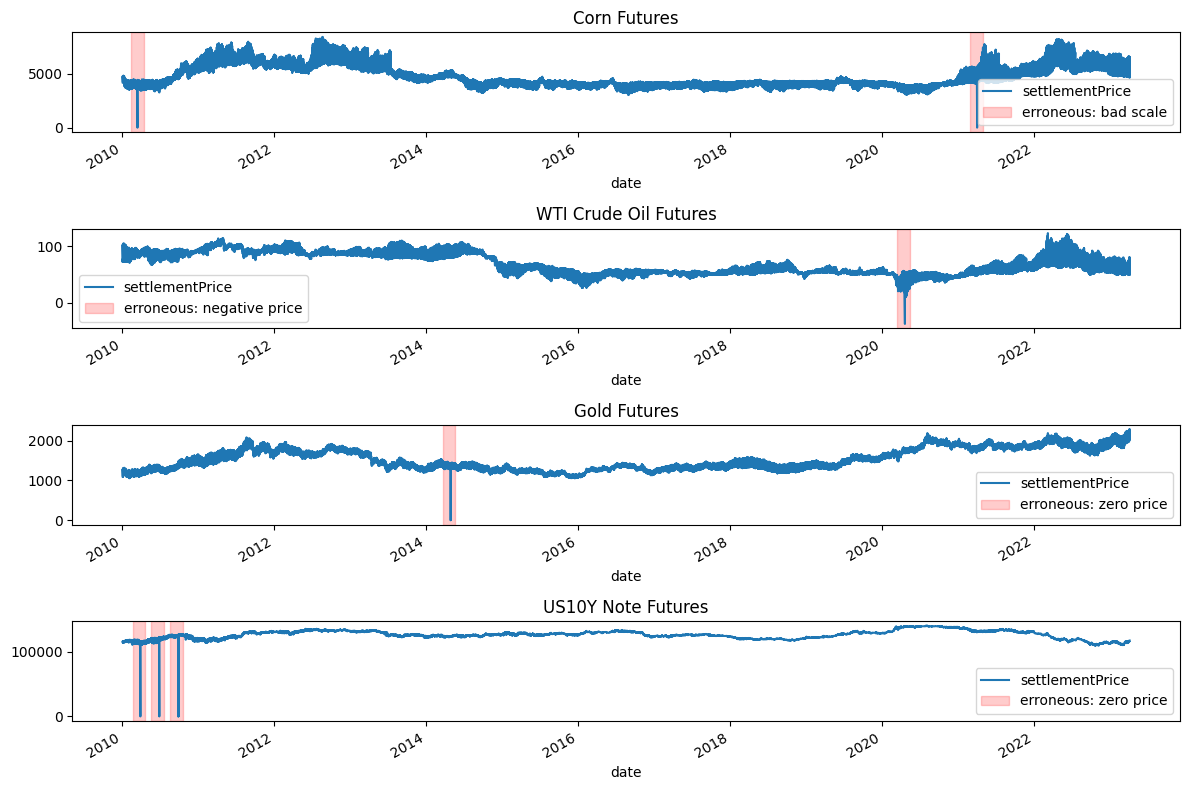

In [ ]:
fig, axes = plt.subplots(4,1,figsize=(12,8))
for i, (label, df) in enumerate(dfFutures.groupby('symbol')):
    ax = axes[i]
    df['settlementPrice'].reset_index().plot(x='date', ax=ax)
    if label == 'C':
        ax.axvspan('2010-02-14', '2010-04-14', color='red', alpha=0.2, label='erroneous: bad scale')
        ax.axvspan('2021-03-01', '2021-05-01', color='red', alpha=0.2)
    elif label == 'CL':
        ax.axvspan('2020-03-14', '2020-05-14', color='red', alpha=0.2, label='erroneous: negative price')
    elif label == 'GC':
        ax.axvspan('2014-03-21', '2014-05-21', color='red', alpha=0.2, label='erroneous: zero price')
    elif label == 'TYF':
        ax.axvspan('2010-02-21', '2010-04-21', color='red', alpha=0.2, label='erroneous: zero price')
        ax.axvspan('2010-05-21', '2010-07-21', color='red', alpha=0.2,)
        ax.axvspan('2010-08-21', '2010-10-21', color='red', alpha=0.2,)
    ax.set_title(f'{FuturesSymbols[label]}')
    ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
# Corn settlement price on 2021-04-02 is erroneously scaled by 1/1000
dfFutures.loc[('C', '2021-04-02'), 'settlementPrice'] = dfFutures.loc[('C', '2021-04-02'), 'settlementPrice'].transform(lambda x: x*1000)

In [ ]:
dfFutures.loc[:,'settlementPrice'].clip(0, inplace=True)
dfFutures.loc[:,'openPrice'].replace({0.0: np.nan}, inplace=True)
dfFutures.loc[:,'settlementPrice'].replace({0.0: np.nan}, inplace=True)

In [ ]:
dfFutures.groupby('symbol').head(2)

settlementPrice openInterest  totalVolume  \
symbol date       expiration                                              
C      2010-01-04 2010-03             4184.00       500339       140553   
                  2010-05             4286.00       127618        19409   
CL     2010-01-04 2009-12               76.72          0.0            0   
                  2010-01               72.47          0.0            0   
GC     2010-01-04 2009-12             1097.00          0.0            0   
                  2010-01             1117.70        148.0          184   
TYF    2010-01-04 2010-03           115170.00    1236399.0       611675   
                  2010-06           114035.00        306.0           62   

                                volume  openPrice  highPrice  lowPrice  \
symbol date       expiration                                             
C      2010-01-04 2010-03     126410.0     4156.0     4262.0    4132.0   
                  2010-05      18474.0     4246.0     4360.0    4234.0   
CL     2010-01-04 2009-12          NaN        NaN        NaN       NaN   
                  2010-01          NaN        NaN        NaN       NaN   
GC     2010-01-04 2009-12          NaN        NaN        NaN       NaN   
                  2010-01        184.0     1097.1     1122.3    1097.1   
TYF    2010-01-04 2010-03     573053.0   115060.0   115235.0  114310.0   
                  2010-06         62.0   114065.0   114095.0  113210.0   

                             lastTradeDate  
symbol date       expiration                
C      2010-01-04 2010-03              NaT  
                  2010-05              NaT  
CL     2010-01-04 2009-12              NaT  
                  2010-01              NaT  
GC     2010-01-04 2009-12              NaT  
                  2010-01              NaT  
TYF    2010-01-04 2010-03              NaT  
                  2010-06              NaT

In [ ]:
df = dfFutures

# Calculate price gap along each symbol tenor
df = df.assign(
  priceGap = dfFutures.groupby(['symbol', 'expiration'])\
    .apply(lambda x: x['settlementPrice'] - x['settlementPrice'].shift(1))\
    .droplevel(list(range(2))))
# Isolate most active tenor per day
df = df.loc[df.groupby(['symbol', 'date'])['totalVolume'].idxmax().values]
# Calculate gap duration in number of trading session days
df = df.assign(gap = df.reset_index().groupby(['symbol'])['date'].diff().dt.days.values)
# Classify change in most active tenor
df = df.assign(rolled = df.reset_index().groupby('symbol').apply(lambda x: x.expiration != x.expiration.shift(1)).values)
# Extra features
# df['HML'] = (df['highPrice'] - df['lowPrice']).groupby('symbol').apply(lambda x: x.fillna(x.mean())).droplevel(1)
df['HML'] = (df['highPrice'] - df['lowPrice']).groupby('symbol').apply(lambda x: x.fillna(x.mean()))
# Cleanup
df.dropna(subset=['priceGap'], inplace=True)
df.drop(columns=['lastTradeDate', 'volume'], inplace=True)
df[['openInterest', 'volume']] = df[['openInterest', 'totalVolume']].astype(int)
df.drop(columns=['totalVolume'], inplace=True)
dfFuturesActiveTenor = df

<ipython-input-12-7e5e2be1f3b6>:16: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['HML'] = (df['highPrice'] - df['lowPrice']).groupby('symbol').apply(lambda x: x.fillna(x.mean()))


In [ ]:
dfFuturesActiveTenor.groupby('symbol').head(2)

settlementPrice  openInterest  openPrice  \
symbol date       expiration                                             
C      2010-01-05 2010-03             4186.00        499878    4172.00   
       2010-01-06 2010-03             4216.00        500500    4180.00   
CL     2010-01-05 2010-02               81.77        293753      81.63   
       2010-01-06 2010-02               83.18        290855      81.43   
GC     2010-01-05 2010-02             1118.70        321487    1122.00   
       2010-01-06 2010-02             1136.50        323475    1118.50   
TYF    2010-01-05 2010-03           116065.00       1226379  115210.00   
       2010-01-06 2010-03           115310.00       1218617  116040.00   

                              highPrice   lowPrice  priceGap  gap  rolled  \
symbol date       expiration                                                
C      2010-01-05 2010-03       4200.00    4152.00      2.00  1.0   False   
       2010-01-06 2010-03       4220.00    4160.00     30.00  1.0   False   
CL     2010-01-05 2010-02         82.00      80.95      0.26  1.0   False   
       2010-01-06 2010-02         83.52      80.85      1.41  1.0   False   
GC     2010-01-05 2010-02       1129.60    1115.50      0.40  1.0   False   
       2010-01-06 2010-02       1141.00    1116.80     17.80  1.0   False   
TYF    2010-01-05 2010-03     116085.00  115190.00    895.00  1.0   False   
       2010-01-06 2010-03     116055.00  115205.00   -755.00  1.0   False   

                                 HML  volume  
symbol date       expiration                  
C      2010-01-05 2010-03      48.00   80967  
       2010-01-06 2010-03      60.00   96453  
CL     2010-01-05 2010-02       1.05  258887  
       2010-01-06 2010-02       2.67  370059  
GC     2010-01-05 2010-02      14.10  156414  
       2010-01-06 2010-02      24.20  176903  
TYF    2010-01-05 2010-03     895.00  750738  
       2010-01-06 2010-03     850.00  854860

In [ ]:
dfFuturesActiveTenor_C_gap = dfFuturesActiveTenor.loc['C']['priceGap']
dfFuturesActiveTenor_C_gap.tail()

date        expiration
2023-03-30  2023-05       -10.0
2023-03-31  2023-05       110.0
2023-04-03  2023-05       -28.0
2023-04-04  2023-05       -40.0
2023-04-05  2023-05       -10.0
Name: priceGap, dtype: float64

In [ ]:
m = dict(zip(['clvl', 'cvl', 'gcvl', 'tyvl'],['CL', 'C', 'GC', 'TYF']))
df = dfCVOL.loc[m.keys()]
df.index = df.index.map(lambda x: (m[x[0]], x[1]))
df = dfFuturesActiveTenor.join(df, how='inner', validate='1:1')
dfFinal = df
dfFinal.reset_index(level='expiration', inplace=True)
dfFinal.groupby('symbol').head(2)

expiration  settlementPrice  openInterest  openPrice  \
symbol date                                                              
C      2013-10-01    2013-12          4390.00        725242    4412.00   
       2013-10-02    2013-12          4390.00        723285    4386.00   
CL     2013-10-01    2013-11           102.04        302603     102.31   
       2013-10-02    2013-11           104.10        300767     101.62   
GC     2013-10-01    2013-12          1286.10        229275    1328.20   
       2013-10-02    2013-12          1320.70        225997    1287.50   
TYF    2013-10-01    2013-12        126040.00       1956553  126135.00   
       2013-10-02    2013-12        126125.00       1958612  126005.00   

                   highPrice   lowPrice  priceGap  gap  rolled     HML  \
symbol date                                                              
C      2013-10-01    4446.00    4352.00    -24.00  1.0   False   94.00   
       2013-10-02    4410.00    4350.00      0.00  1.0   False   60.00   
CL     2013-10-01     102.58     101.06     -0.29  1.0   False    1.52   
       2013-10-02     104.23     101.43      2.06  1.0   False    2.80   
GC     2013-10-01    1337.80    1282.40    -40.90  1.0   False   55.40   
       2013-10-02    1324.20    1276.90     34.60  1.0   False   47.30   
TYF    2013-10-01  126140.00  126000.00    -85.00  1.0   False  140.00   
       2013-10-02  126210.00  125305.00     85.00  1.0   False  905.00   

                    volume     cvol    dnvar    upvar    skew  skewRatio  \
symbol date                                                                
C      2013-10-01   162610  23.8362  23.7366  23.9355  0.1989     1.0084   
       2013-10-02   110682  22.0788  22.1495  22.0078 -0.1417     0.9936   
CL     2013-10-01   223028  22.3796  23.2627  21.4603 -1.8024     0.9225   
       2013-10-02   300526  20.7124  21.2193  20.1927 -1.0266     0.9516   
GC     2013-10-01   212833  24.4079  25.9769  22.7310 -3.2459     0.8750   
       2013-10-02   176119  22.6774  23.9102  21.3737 -2.5365     0.8939   
TYF    2013-10-01  1096668   6.3251   6.7344   5.8874 -0.8469     0.8742   
       2013-10-02  1109162   5.9678   6.3480   5.5616 -0.7863     0.8761   

                       ATM  convexity   underlying  
symbol date                                         
C      2013-10-01  22.3588     1.0661   439.000000  
       2013-10-02  20.9640     1.0532   439.000000  
CL     2013-10-01  21.2972     1.0508   102.040000  
       2013-10-02  19.6737     1.0528   104.100000  
GC     2013-10-01  22.3812     1.0906  1286.100000  
       2013-10-02  20.4460     1.1091  1320.700000  
TYF    2013-10-01   6.1749     1.0243   126.125000  
       2013-10-02   5.8383     1.0222   126.390625

In [ ]:
scalers = 10**np.log10((dfFinal['settlementPrice'] / dfFinal['underlying']).groupby('symbol').mean()).round()
scalers

symbol
C        10.0
CL        1.0
GC        1.0
TYF    1000.0
dtype: float64

In [ ]:
foi = ['settlementPrice', 'openPrice', 'highPrice', 'lowPrice', 'priceGap', 'HML']
dfFinal[foi] = dfFinal[foi].groupby('symbol').apply(lambda x: x/scalers[x.name])
dfFinal[foi[1:]] = dfFinal[foi[1:]].div(dfFinal['settlementPrice'], axis=0)

<ipython-input-17-67ac15ef93e1>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  dfFinal[foi] = dfFinal[foi].groupby('symbol').apply(lambda x: x/scalers[x.name])


In [ ]:
foi = ['cvol', 'dnvar', 'upvar', 'ATM', 'skew']
dfFinal[foi] = dfFinal[foi].apply(lambda x: x/(100*np.sqrt(365)))

In [ ]:
dfFinal.drop(columns=['underlying'], inplace=True)

In [ ]:
dfFinal.groupby('symbol').head(2)

expiration  settlementPrice  openInterest  openPrice  \
symbol date                                                              
C      2013-10-01    2013-12          439.000        725242   1.005011   
       2013-10-02    2013-12          439.000        723285   0.999089   
CL     2013-10-01    2013-11          102.040        302603   1.002646   
       2013-10-02    2013-11          104.100        300767   0.976177   
GC     2013-10-01    2013-12         1286.100        229275   1.032735   
       2013-10-02    2013-12         1320.700        225997   0.974862   
TYF    2013-10-01    2013-12          126.040       1956553   1.000754   
       2013-10-02    2013-12          126.125       1958612   0.999049   

                   highPrice  lowPrice  priceGap  gap  rolled       HML  \
symbol date                                                               
C      2013-10-01   1.012756  0.991344 -0.005467  1.0   False  0.021412   
       2013-10-02   1.004556  0.990888  0.000000  1.0   False  0.013667   
CL     2013-10-01   1.005292  0.990396 -0.002842  1.0   False  0.014896   
       2013-10-02   1.001249  0.974352  0.019789  1.0   False  0.026897   
GC     2013-10-01   1.040199  0.997123 -0.031802  1.0   False  0.043076   
       2013-10-02   1.002650  0.966836  0.026198  1.0   False  0.035814   
TYF    2013-10-01   1.000793  0.999683 -0.000674  1.0   False  0.001111   
       2013-10-02   1.000674  0.993499  0.000674  1.0   False  0.007175   

                    volume      cvol     dnvar     upvar      skew  skewRatio  \
symbol date                                                                     
C      2013-10-01   162610  0.012476  0.012424  0.012528  0.000104     1.0084   
       2013-10-02   110682  0.011557  0.011594  0.011519 -0.000074     0.9936   
CL     2013-10-01   223028  0.011714  0.012176  0.011233 -0.000943     0.9225   
       2013-10-02   300526  0.010841  0.011107  0.010569 -0.000537     0.9516   
GC     2013-10-01   212833  0.012776  0.013597  0.011898 -0.001699     0.8750   
       2013-10-02   176119  0.011870  0.012515  0.011188 -0.001328     0.8939   
TYF    2013-10-01  1096668  0.003311  0.003525  0.003082 -0.000443     0.8742   
       2013-10-02  1109162  0.003124  0.003323  0.002911 -0.000412     0.8761   

                        ATM  convexity  
symbol date                             
C      2013-10-01  0.011703     1.0661  
       2013-10-02  0.010973     1.0532  
CL     2013-10-01  0.011147     1.0508  
       2013-10-02  0.010298     1.0528  
GC     2013-10-01  0.011715     1.0906  
       2013-10-02  0.010702     1.1091  
TYF    2013-10-01  0.003232     1.0243  
       2013-10-02  0.003056     1.0222

In [ ]:
zq = lambda z: 2*scipy.stats.norm.cdf(z) - 1
quantiles = [zq(1), zq(2), zq(3), 1]
horizons = [7, 15, 30, 45]
jobs = product(horizons, quantiles)
with multiprocessing.Pool() as pool:
    df = abs(dfFinal.loc[::-1, 'priceGap'])
    t = pd.concat(
        pool.starmap(partial(forward_price_gap, df), jobs),
        axis=1,
        join='inner',
        sort=True)

In [ ]:
dfFinal = dfFinal.join(t, how='inner', validate='1:1')

In [ ]:
dfFinal.groupby('symbol').head(2)

expiration  settlementPrice  openInterest  openPrice  \
symbol date                                                              
C      2013-10-01    2013-12          439.000        725242   1.005011   
       2013-10-02    2013-12          439.000        723285   0.999089   
CL     2013-10-01    2013-11          102.040        302603   1.002646   
       2013-10-02    2013-11          104.100        300767   0.976177   
GC     2013-10-01    2013-12         1286.100        229275   1.032735   
       2013-10-02    2013-12         1320.700        225997   0.974862   
TYF    2013-10-01    2013-12          126.040       1956553   1.000754   
       2013-10-02    2013-12          126.125       1958612   0.999049   

                   highPrice  lowPrice  priceGap  gap  rolled       HML  ...  \
symbol date                                                              ...   
C      2013-10-01   1.012756  0.991344 -0.005467  1.0   False  0.021412  ...   
       2013-10-02   1.004556  0.990888  0.000000  1.0   False  0.013667  ...   
CL     2013-10-01   1.005292  0.990396 -0.002842  1.0   False  0.014896  ...   
       2013-10-02   1.001249  0.974352  0.019789  1.0   False  0.026897  ...   
GC     2013-10-01   1.040199  0.997123 -0.031802  1.0   False  0.043076  ...   
       2013-10-02   1.002650  0.966836  0.026198  1.0   False  0.035814  ...   
TYF    2013-10-01   1.000793  0.999683 -0.000674  1.0   False  0.001111  ...   
       2013-10-02   1.000674  0.993499  0.000674  1.0   False  0.007175  ...   

                   15DFPG_q99  15DFPG_q100  30DFPG_q68  30DFPG_q95  \
symbol date                                                          
C      2013-10-01    0.017135     0.017210    0.010480    0.017416   
       2013-10-02    0.017135     0.017210    0.010480    0.017416   
CL     2013-10-01    0.019754     0.019789    0.013742    0.018559   
       2013-10-02    0.019754     0.019789    0.013742    0.018559   
GC     2013-10-01    0.031650     0.031802    0.011673    0.030810   
       2013-10-02    0.026102     0.026198    0.011673    0.026401   
TYF    2013-10-01    0.006138     0.006145    0.000781    0.006460   
       2013-10-02    0.006417     0.006424    0.000781    0.006460   

                   30DFPG_q99  30DFPG_q100  45DFPG_q68  45DFPG_q95  \
symbol date                                                          
C      2013-10-01    0.021568     0.021830    0.009025    0.017862   
       2013-10-02    0.021568     0.021830    0.009800    0.017862   
CL     2013-10-01    0.019716     0.019789    0.013560    0.019296   
       2013-10-02    0.019716     0.019789    0.013560    0.019296   
GC     2013-10-01    0.031743     0.031802    0.010936    0.028682   
       2013-10-02    0.030505     0.030763    0.007987    0.024571   
TYF    2013-10-01    0.007189     0.007235    0.001663    0.007060   
       2013-10-02    0.007189     0.007235    0.001663    0.007060   

                   45DFPG_q99  45DFPG_q100  
symbol date                                 
C      2013-10-01    0.021534     0.021830  
       2013-10-02    0.021534     0.021830  
CL     2013-10-01    0.022331     0.022571  
       2013-10-02    0.022331     0.022571  
GC     2013-10-01    0.031712     0.031802  
       2013-10-02    0.030369     0.030763  
TYF    2013-10-01    0.007946     0.008014  
       2013-10-02    0.007946     0.008014  

[8 rows x 34 columns]

In [ ]:
dfFinal.gap = dfFinal.gap.astype(int)

In [ ]:
dfFinal.groupby('symbol').head(2)

expiration  settlementPrice  openInterest  openPrice  \
symbol date                                                              
C      2013-10-01    2013-12          439.000        725242   1.005011   
       2013-10-02    2013-12          439.000        723285   0.999089   
CL     2013-10-01    2013-11          102.040        302603   1.002646   
       2013-10-02    2013-11          104.100        300767   0.976177   
GC     2013-10-01    2013-12         1286.100        229275   1.032735   
       2013-10-02    2013-12         1320.700        225997   0.974862   
TYF    2013-10-01    2013-12          126.040       1956553   1.000754   
       2013-10-02    2013-12          126.125       1958612   0.999049   

                   highPrice  lowPrice  priceGap  gap  rolled       HML  ...  \
symbol date                                                              ...   
C      2013-10-01   1.012756  0.991344 -0.005467    1   False  0.021412  ...   
       2013-10-02   1.004556  0.990888  0.000000    1   False  0.013667  ...   
CL     2013-10-01   1.005292  0.990396 -0.002842    1   False  0.014896  ...   
       2013-10-02   1.001249  0.974352  0.019789    1   False  0.026897  ...   
GC     2013-10-01   1.040199  0.997123 -0.031802    1   False  0.043076  ...   
       2013-10-02   1.002650  0.966836  0.026198    1   False  0.035814  ...   
TYF    2013-10-01   1.000793  0.999683 -0.000674    1   False  0.001111  ...   
       2013-10-02   1.000674  0.993499  0.000674    1   False  0.007175  ...   

                   15DFPG_q99  15DFPG_q100  30DFPG_q68  30DFPG_q95  \
symbol date                                                          
C      2013-10-01    0.017135     0.017210    0.010480    0.017416   
       2013-10-02    0.017135     0.017210    0.010480    0.017416   
CL     2013-10-01    0.019754     0.019789    0.013742    0.018559   
       2013-10-02    0.019754     0.019789    0.013742    0.018559   
GC     2013-10-01    0.031650     0.031802    0.011673    0.030810   
       2013-10-02    0.026102     0.026198    0.011673    0.026401   
TYF    2013-10-01    0.006138     0.006145    0.000781    0.006460   
       2013-10-02    0.006417     0.006424    0.000781    0.006460   

                   30DFPG_q99  30DFPG_q100  45DFPG_q68  45DFPG_q95  \
symbol date                                                          
C      2013-10-01    0.021568     0.021830    0.009025    0.017862   
       2013-10-02    0.021568     0.021830    0.009800    0.017862   
CL     2013-10-01    0.019716     0.019789    0.013560    0.019296   
       2013-10-02    0.019716     0.019789    0.013560    0.019296   
GC     2013-10-01    0.031743     0.031802    0.010936    0.028682   
       2013-10-02    0.030505     0.030763    0.007987    0.024571   
TYF    2013-10-01    0.007189     0.007235    0.001663    0.007060   
       2013-10-02    0.007189     0.007235    0.001663    0.007060   

                   45DFPG_q99  45DFPG_q100  
symbol date                                 
C      2013-10-01    0.021534     0.021830  
       2013-10-02    0.021534     0.021830  
CL     2013-10-01    0.022331     0.022571  
       2013-10-02    0.022331     0.022571  
GC     2013-10-01    0.031712     0.031802  
       2013-10-02    0.030369     0.030763  
TYF    2013-10-01    0.007946     0.008014  
       2013-10-02    0.007946     0.008014  

[8 rows x 34 columns]

## Calendar Data

In [ ]:
import requests
import json
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
# My API Key
api_key = "79c0b915d74452babdb16f3385408adb"

In [ ]:
# Create an empty global dataframe
data = pd.DataFrame(columns=["release_id", "release_name", "date"])

In [ ]:
for i in range(2013, 2024): # year 2013 - 2023
    for j in range(1,13): # month 1 - 12
        if j < 10: # if month is between January(01) to September(09). For the purpose of formatting date in url.
            if j == 9:
                year1 = str(i) # convert int to string
                month1 = str(j).rjust(2, '0') # the month in date format is 01, 02...but j here is 1, 2...so we have to add a zero in the front after converting the int to string
                month2 = str(j+1) # (October) two digits month does not need a zero in front.
                url = 'https://api.stlouisfed.org/fred/releases/dates?&realtime_start={year1}-{month1}-02&realtime_end={year1}-{month2}-01&api_key={api_key}&file_type=json'.format(api_key=api_key, year1=year1, month1=month1, month2=month2)
            else:
                year1 = str(i)
                # since the month1 and month2 are both single digit, we have to add a zero in front after converting it to string
                month1 = str(j).rjust(2, '0')
                month2 = str(j+1).rjust(2, '0')
                url = 'https://api.stlouisfed.org/fred/releases/dates?&realtime_start={year1}-{month1}-02&realtime_end={year1}-{month2}-01&api_key={api_key}&file_type=json'.format(api_key=api_key, year1=year1, month1=month1, month2=month2)
        else: # if month is October, November, December
            if j == 12: # if the month is December, the year2 would be the next year.
                year1 = str(i)
                year2 = str(i+1)
                month1 = str(j)
                month2 = "01"
                url = 'https://api.stlouisfed.org/fred/releases/dates?&realtime_start={year1}-{month1}-02&realtime_end={year2}-{month2}-01&api_key={api_key}&file_type=json'.format(api_key=api_key, year1=year1, year2=year2, month1=month1, month2=month2)
            else:# Otherwise, keep it usual.
                year1 = str(i)
                month1 = str(j)
                month2 = str(j+1)
                url = 'https://api.stlouisfed.org/fred/releases/dates?&realtime_start={year1}-{month1}-02&realtime_end={year1}-{month2}-01&api_key={api_key}&file_type=json'.format(api_key=api_key, year1=year1, month1=month1, month2=month2)
        r = requests.get(url)
        # get the data
        item_dict = json.loads(r.text)
        # create a instance in this scope to store the data
        my_df = pd.DataFrame(columns=["release_id", "release_name", "date"])
        for item in item_dict['release_dates']:
            # append the data to my_df
            my_df = my_df.append(item, ignore_index=True)
        my_df = my_df[::-1] # reverse the order, because the original order is desc.
        data = pd.concat([data, my_df], ignore_index = True)# concat the data for each month to our global dataframe.

In [ ]:
data

,release_id,release_name,date
0,234,World Development Indicators,2013-01-02
1,102,Wall Street Journal,2013-01-02
2,245,Summary Measures of the Foreign Exchange Value...,2013-01-02
3,206,Quarterly National Accounts,2013-01-02
4,205,Main Economic Indicators,2013-01-02
...,...,...,...
69411,502,Euro Short Term Rate,2023-07-13
69412,279,Economic Policy Uncertainty,2023-07-13
69413,72,Daily Treasury Inflation-Indexed Securities,2023-07-13
69414,86,Commercial Paper,2023-07-13


In [ ]:
# Pivot the dataframe. If the value of the cells is not NaN, it stands for the event happens on that date.
dta1 = data.pivot(index='date', columns='release_name')
cat_dta1 = dta1.notnull().astype('int')

# Add a 'Date' column for joining the dataframe and convert the data type to datetime
cat_dta1['Date'] = list(cat_dta1.index)
cat_dta1['Date'] = pd.to_datetime(cat_dta1.Date)

In [ ]:
dist_df = dfFuturesActiveTenor_C_gap.reset_index(level=[0,1])
dist_df.rename(columns = {'date':'Date'}, inplace = True)
dist_df['Date'].astype('object')
dist_df

,Date,expiration,priceGap
0,2010-01-05,2010-03,2.0
1,2010-01-06,2010-03,30.0
2,2010-01-07,2010-03,-42.0
3,2010-01-08,2010-03,56.0
4,2010-01-11,2010-03,-6.0
...,...,...,...
3336,2023-03-30,2023-05,-10.0
3337,2023-03-31,2023-05,110.0
3338,2023-04-03,2023-05,-28.0
3339,2023-04-04,2023-05,-40.0


In [ ]:
# Add the priceGap feature to calendar event data features by joining the dataframes on date
df_final = pd.merge(dist_df, cat_dta1, on = "Date", how = "right")
df_final

,Date,expiration,priceGap,"(release_id, A Millennium of Macroeconomic Data for the UK)","(release_id, ADP National Employment Report)","(release_id, Advance Economic Indicators)","(release_id, Advance Monthly Sales for Retail and Food Services)","(release_id, Age-Adjusted Premature Death Rate)","(release_id, Alternative Measures of Labor Underutilization for States)","(release_id, American Community Survey)",...,"(release_id, Weekly Treasury Inflation-Indexed Securities)","(release_id, Weekly and Hourly Earnings from the Current Population Survey)","(release_id, Western Hemisphere Regional Economic Outlook)","(release_id, Wilshire Indexes)","(release_id, World Development Indicators)","(release_id, World Economic Outlook)","(release_id, World Uncertainty Index)","(release_id, Z.1 Financial Accounts of the United States)","(release_id, Z.1 Flow of Funds Accounts of the United States)","(release_id, Zillow Home Value Index (ZHVI))"
0,2013-01-02,2013-03,-76.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2013-01-03,2013-03,-14.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-04,2013-03,-90.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-07,2013-03,52.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2013-01-08,2013-03,32.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,2023-07-09,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3272,2023-07-10,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3273,2023-07-11,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3274,2023-07-12,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
df_final1 = df_final.drop(columns=['Date', 'expiration'], axis=1)
df_final1 = df_final1.dropna(subset=['priceGap'])

In [ ]:
events_name = []
column_name = df_final1.columns
for i in range(1, len(column_name)):
  events_name.append(column_name[i][1])
events_name.insert(0, 'priceGap')
df_final1.columns = events_name
df_final1

,priceGap,A Millennium of Macroeconomic Data for the UK,ADP National Employment Report,Advance Economic Indicators,Advance Monthly Sales for Retail and Food Services,Age-Adjusted Premature Death Rate,Alternative Measures of Labor Underutilization for States,American Community Survey,An Arbitrage-Free Three-Factor Term Structure Model and the Recent Behavior of Long-Term Yields and Distant-Horizon Forward Rates,Annual Estimates of the Population for Counties,...,Weekly Treasury Inflation-Indexed Securities,Weekly and Hourly Earnings from the Current Population Survey,Western Hemisphere Regional Economic Outlook,Wilshire Indexes,World Development Indicators,World Economic Outlook,World Uncertainty Index,Z.1 Financial Accounts of the United States,Z.1 Flow of Funds Accounts of the United States,Zillow Home Value Index (ZHVI)
0,-76.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,-14.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-90.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,52.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,32.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170,-10.0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3171,110.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3174,-28.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3175,-40.0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0


In [ ]:
# Find the correlation of priceGap to all the calendar events
corr_gap_events = df_final1.corr().loc['priceGap']
# Select top 20 positively and negatively correlated events
Top_20_event_neg = corr_gap_events.sort_values()[:20]
Top_20_event_pos = corr_gap_events.sort_values(ascending = False)[1:21]

In [ ]:
Top_20_event_neg

Wall Street Journal                                            -0.066930
Community Bank Sentiment Index                                 -0.058576
Bankstats (Monetary & Financial Statistics)                    -0.056382
Total Energy                                                   -0.055048
G.5 Foreign Exchange Rates                                     -0.043087
Job Openings and Labor Turnover Survey                         -0.042728
Cass Freight Index Report                                      -0.040376
Senior Loan Officer Opinion Survey on Bank Lending Practices   -0.036761
Failures and Assistance Transactions                           -0.034177
BofA Merrill Lynch                                             -0.032363
House Price Index                                              -0.030779
FDIC Quarterly Banking Profile                                 -0.030666
Tech Pulse                                                     -0.030023
Weekly Treasury Inflation-Indexed Securities       

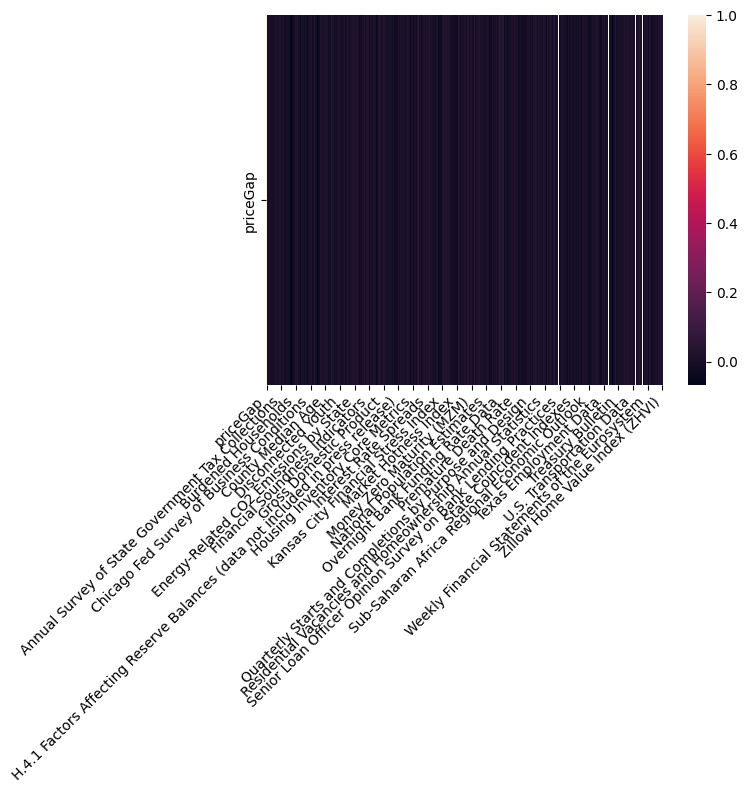

In [ ]:
import seaborn as sns
ax = sns.heatmap(df_final1.corr().loc[['priceGap'], :])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
Top_20_event_pos

Optimal Blue Mortgage Market Indices                                         0.056199
Penn World Table 10.0                                                        0.050737
ICE BofA Indices                                                             0.047647
Survey of Business Uncertainty                                               0.047517
Monthly State Retail Sales                                                   0.045725
Key ECB Interest Rates                                                       0.043115
Secured Overnight Financing Rate Data                                        0.042677
United Kingdom Main Aggregates of National Accounts                          0.042064
Credit to private sector                                                     0.040476
Weekly Retail Gasoline and Diesel Prices                                     0.039497
Market Value of U.S. Government Debt                                         0.039110
Coinbase Cryptocurrencies                             

Feature Engineering

In [ ]:
data = dfFinal.loc['C', ['settlementPrice','volume', 'openInterest','skew', 'skewRatio', 'convexity', 'HML', 'gap']]
data['Date'] = pd.to_datetime(data.index)

data.head()

,settlementPrice,volume,openInterest,skew,skewRatio,convexity,HML,gap,Date
date,,,,,,,,,
2013-10-01,439.0,162610,725242,0.000104,1.0084,1.0661,0.021412,1,2013-10-01
2013-10-02,439.0,110682,723285,-0.000074,0.9936,1.0532,0.013667,1,2013-10-02
2013-10-03,439.2,97170,724420,0.000137,1.0123,1.0597,0.012750,1,2013-10-03
2013-10-04,443.2,80706,720829,0.000364,1.0347,1.0423,0.011282,1,2013-10-04
2013-10-07,449.2,148378,718884,0.000290,1.0261,1.0564,0.017809,3,2013-10-07


In [ ]:
# Make the most correlated events as new features
df_event = pd.concat([df_final1[Top_20_event_pos.index], df_final1[Top_20_event_neg.index]], axis=1)
df_event.insert(loc = 0,
          column = 'Date',
          value = df_final['Date'])

df_event.head()

,Date,Optimal Blue Mortgage Market Indices,Penn World Table 10.0,ICE BofA Indices,Survey of Business Uncertainty,Monthly State Retail Sales,Key ECB Interest Rates,Secured Overnight Financing Rate Data,United Kingdom Main Aggregates of National Accounts,Credit to private sector,...,House Price Index,FDIC Quarterly Banking Profile,Tech Pulse,Weekly Treasury Inflation-Indexed Securities,Quarterly National Accounts,Job Postings on Indeed,New Patent Assignments,Construction Spending,Penn World Table 10.01,Weekly National Rates and Rate Caps
0,2013-01-02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,2013-01-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-07,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,2013-01-08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Add the new feat
df_input = pd.merge(data, df_event, on = "Date", how = "left")
df_input = df_input.dropna()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns = ['volume', 'openInterest']
df_input[columns] = scaler.fit_transform(df_input[columns])
df_input = df_input.drop(columns=['settlementPrice'], axis=1)
df_input = pd.get_dummies(data=df_input, columns=['gap'])

df_input

,volume,openInterest,skew,skewRatio,convexity,HML,Date,Optimal Blue Mortgage Market Indices,Penn World Table 10.0,ICE BofA Indices,...,Quarterly National Accounts,Job Postings on Indeed,New Patent Assignments,Construction Spending,Penn World Table 10.01,Weekly National Rates and Rate Caps,gap_1,gap_2,gap_3,gap_4
0,0.310414,0.704079,0.000104,1.0084,1.0661,0.021412,2013-10-01,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,0.211286,0.701986,-0.000074,0.9936,1.0532,0.013667,2013-10-02,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2,0.185492,0.703200,0.000137,1.0123,1.0597,0.012750,2013-10-03,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
3,0.154063,0.699358,0.000364,1.0347,1.0423,0.011282,2013-10-04,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
4,0.283246,0.697278,0.000290,1.0261,1.0564,0.017809,2013-10-07,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390,0.299119,0.409263,0.000463,1.0377,1.1035,0.015068,2023-03-29,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2391,0.228092,0.399963,0.000519,1.0405,1.1061,0.010163,2023-03-30,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2392,0.385401,0.387554,0.000650,1.0595,1.1193,0.026045,2023-03-31,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2393,0.293730,0.380935,0.000166,1.0151,1.1029,0.018856,2023-04-03,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0


In [ ]:
lst = ['cvol', '15DFPG_q95', '15DFPG_q99',	'15DFPG_q100',	'30DFPG_q68',	'30DFPG_q95',	'30DFPG_q99',	'30DFPG_q100',	'45DFPG_q68',	'45DFPG_q95',	'45DFPG_q99',	'45DFPG_q100']
response = dfFinal.loc['C', lst]
response['Date'] = dfFinal.loc['C'].index
response['y'] = get_response(response, 15, 2)
response

,cvol,15DFPG_q95,15DFPG_q99,15DFPG_q100,30DFPG_q68,30DFPG_q95,30DFPG_q99,30DFPG_q100,45DFPG_q68,45DFPG_q95,45DFPG_q99,45DFPG_q100,Date,y
date,,,,,,,,,,,,,,
2013-10-01,0.012476,0.015947,0.017135,0.017210,0.010480,0.017416,0.021568,0.021830,0.009025,0.017862,0.021534,0.021830,2013-10-01,0.009006
2013-10-02,0.011557,0.015947,0.017135,0.017210,0.010480,0.017416,0.021568,0.021830,0.009800,0.017862,0.021534,0.021830,2013-10-02,0.007166
2013-10-03,0.011193,0.015947,0.017135,0.017210,0.010480,0.017416,0.021568,0.021830,0.010021,0.017916,0.021544,0.021830,2013-10-03,0.006439
2013-10-04,0.010685,0.015947,0.017135,0.017210,0.010988,0.017626,0.021581,0.021830,0.010175,0.017971,0.021553,0.021830,2013-10-04,0.005422
2013-10-07,0.011253,0.015947,0.017135,0.017210,0.010480,0.017416,0.021568,0.021830,0.011370,0.020269,0.024061,0.024272,2013-10-07,0.006558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29,0.012511,0.014739,0.016543,0.016657,0.005797,0.014739,0.016543,0.016657,0.005797,0.014739,0.016543,0.016657,2023-03-29,0.010282
2023-03-30,0.013054,0.015218,0.016571,0.016657,0.006626,0.015218,0.016571,0.016657,0.006626,0.015218,0.016571,0.016657,2023-03-30,0.010890
2023-03-31,0.011252,0.015698,0.016600,0.016657,0.009970,0.015698,0.016600,0.016657,0.009970,0.015698,0.016600,0.016657,2023-03-31,0.006807


Save as Parquet files

In [ ]:
df_input.to_parquet("features_with_events.parquet")
response.to_parquet("response.parquet")